In [ ]:
import transforms as transforms
import population as population
import optimize as optimize
import utility as utility
import pandas as pd
import numpy as np
import visualization as visualization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import evaluation as evaluation


data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values

#x_raw, x_ind = train_test_split(x_raw_presplit, test_size=0.1, shuffle=False)

dirpath = utility.fetch_new_run_dirpath()



pop = population.generate_random_forest(100, 12)

np.seterr(all='ignore')
best_forest, best_scores, best_overtime = optimize.optimize_constants(
    pop, x_raw, sthresh_q=.1, run_dir=dirpath, max_iter=2, vizout=False
)

img = visualization.visualize_tree(best_forest[best_scores.index(min(best_scores))], run_dir=dirpath, vizout=True)
best_forest , best_scores = population.extract_n_best_trees(best_forest, best_scores, -1, run_dir=dirpath, vizout=True)


ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)


x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)

#using time column (never utilized) as noise column
x_raw[:, 0] = 1
noise = np.random.rand(x_raw.shape[0], 1)

x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = evaluation.standard_NN_construction(X_train, y_train, verbose=1)
evaluation.standard_LM_evaluation(X_train, X_test, y_train, y_test, model, dirpath, vizout=True, show=True)
#evaluation.standard_LM_evaluation(X_train, xind_, y_train, yind_, model, dirpath, vizout=True)

In [ ]:
import transforms as transforms
import population as population
import optimize as optimize
import utility as utility
import pandas as pd
import numpy as np
import visualization as visualization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import evaluation as evaluation


data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values

#x_raw, x_ind = train_test_split(x_raw_presplit, test_size=0.1, shuffle=False)

dirpath = utility.fetch_new_run_dirpath()



pop = population.generate_random_forest(200, 12)

np.seterr(all='ignore')
best_forest, best_scores, best_overtime = optimize.optimize_constants(
    pop, x_raw, sthresh_q=.1, run_dir=dirpath, max_iter=-1, vizout=True
)

img = visualization.visualize_tree(best_forest[best_scores.index(min(best_scores))], run_dir=dirpath, vizout=True)
best_forest , best_scores = population.extract_n_best_trees(best_forest, best_scores, 10, run_dir=dirpath, vizout=True)


ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)


x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)


#noise = np.random.rand(x_raw.shape[0], 1)
#x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers.schedules import ExponentialDecay

def standard_NN_construction(X_train, y_train, epochs=250, verbose=0):
    

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.65, 
        patience=3, 
        min_lr=1e-6
    )
    early_stopping = EarlyStopping(monitor='loss', patience=25, mode='min', restore_best_weights=True)

    opt  = tf.keras.optimizers.Adam()
    opt2 = tf.keras.optimizers.SGD(learning_rate=0.01)

    def build_model():
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),  
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),       
            tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
        ])
        
        rmse='root_mean_squared_error'

        model.compile(optimizer=opt2, loss='mse', metrics=['R2Score'])
        return model

    with tf.device('/GPU:0'):
        model = build_model()
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, \
                        validation_split=0.2, verbose=verbose, shuffle=True, callbacks=[reduce_lr, early_stopping])
        
    return model, history

In [ ]:
import reproduction
best_forest = reproduction

In [ ]:
import transforms, evaluation
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ynew = np.roll(x_raw[:, 3], shift=-1)
y_ = np.log(ynew / x_raw[:, 3])
#np.random.shuffle(y_)

import serialization

best_forest = serialization.load_forest(where='../../runs/run_5/best.4st')

x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)


#noise = np.random.rand(x_raw.shape[0], 1)
#x_ = np.hstack([x_, noise])


X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, shuffle=True, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = evaluation.standard_LM_construction(X_train, y_train)
evaluation.standard_LM_evaluation(X_train, X_test, y_train, y_test, model, '', vizout=False, show=True)

In [ ]:
import visualization, serialization, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15_ext.csv")
x_raw = data.values

best_trees = []

for i in range(120, 121):
    print('run',i)
    where =str(i)

    try:
        forest = 	serialization.load_forest(	where=str('../../runs/run_'+where+'/best.4st'))
        path_scrs = serialization.load_deeplist(where=str('../../runs/run_'+where+'/path_pscr.hstry'))

    except Exception:
        continue


    print(path_scrs[0][-1])
    art_thresh, ln_plratio = path_scrs[0][-1][0], path_scrs[0][-1][1]
    import evaluation

    pl_arr = evaluation.generate_pl_atrplr(x_raw, art_thresh, ln_plratio)
    x_ = transforms.forest2features(
        population=forest,
        x_raw=x_raw
    )
    bestpls, bestsums, bestthresh = evaluation.evaluate_tree_atrplr_pl(x_, pl_arr)
    #fig, ax = visualization.visualize_cumulative_first_feature_pl(best_pls=bestpls)

    from sklearn.metrics import precision_score

    if('>' in bestthresh[0]):

        preds = x_[:, 0] >0
    else:
        preds = x_[:, 0] <0
    trues = evaluation.generate_solarr_atrplr(x_raw, art_thresh, ln_plratio)
    idx = ~np.isnan(trues)

    best_trees.append(preds)

    ps = precision_score(trues[idx], preds[idx])
    #print('precision: ',ps)
    R = float(np.exp(ln_plratio))
    print('EV: ', (R * ps - ( 1 - ps )))
    #plt.show()

run 120
[1.5384 1.4163 0.7966]
EV:  0.20132117699541652


In [59]:
import visualization, serialization, transforms, evaluation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("../../data/ES15_ext.csv")
x_raw = data.values
from pathlib import Path as path
#best_trees = serialization.load_deeplist(where='best.votes')

In [ ]:
serialization.save_deeplist(where='best.votes')

In [ ]:
from sklearn.metrics import precision_score

xall = np.asarray(best_trees).T

m = 80
n = 50
EV_arr = np.empty((m, n))

yffset = 5
xffset = 0
yscale = 10
xscale = 10

atrthr = 1
ln_plr = 0
for i in range(yffset,m+yffset):
    for j in range(xffset,n+xffset):

        atrthr = (i/yscale)
        ln_plr = (j/xscale)

        y_ = evaluation.generate_solarr_atrplr(x_raw, atrthr, ln_plr)
        idx = ~np.isnan(y_)

        y_ = y_[idx]
        pvpred = evaluation.meta_bipopvote(xall[idx], threshold=0.99)

        ps = precision_score(y_, pvpred)
        #print(ps)

        R = float(np.exp(ln_plr))
        #print(atrthr, ln_plr)
        EV = (R * ps - ( 1 - ps ))
        #print('EV: ', (R * ps - ( 1 - ps )))
        EV_arr[i-yffset, j-xffset] = EV

In [ ]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.ticker as mtick
xscale, yscale = 10, 10
def plot_heatmap(
    data: np.ndarray,
    xlabel: str = 'Exit Ratio',
    ylabel: str = 'Risk Coef',
    title: str = "Expected Value Topology\nof Solution Models' Consensus"
):
    """
    Plot a heatmap of a 2D array where:
      -  0 maps to white (ground) whenever 0 is in range
      - values <  0 map to red shades
      - values >  0 map to green shades
    Automatically handles cases where data is only ≥0 or only ≤0.

    Parameters
    ----------
    data : np.ndarray, shape (M, N)
    xlabel : str, optional
    ylabel : str, optional
    title : str, optional
    """
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)

    # Case 1: data spans negative and positive
    if data_min < 0 < data_max:
        cmap = LinearSegmentedColormap.from_list("r_w_g", ["red", "white", "green"])
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    # Case 2: data all non-negative → white to green
    elif data_min >= 0:
        cmap = LinearSegmentedColormap.from_list("w_g", ["white", "green"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
    # Case 3: data all non-positive → red to white
    else:  # data_max <= 0
        cmap = LinearSegmentedColormap.from_list("r_w", ["red", "white"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=cmap, norm=norm, aspect="auto", interpolation="nearest")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Value")

    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title: ax.set_title(title)
    
    fmt = mtick.FuncFormatter(lambda x, pos: f"{1+x/yscale:.1f}")
    ax.yaxis.set_major_formatter(fmt)
    fmt = mtick.FuncFormatter(lambda x, pos: f"{(np.exp(x/xscale)):.1f}")
    ax.xaxis.set_major_formatter(fmt)


    plt.show()

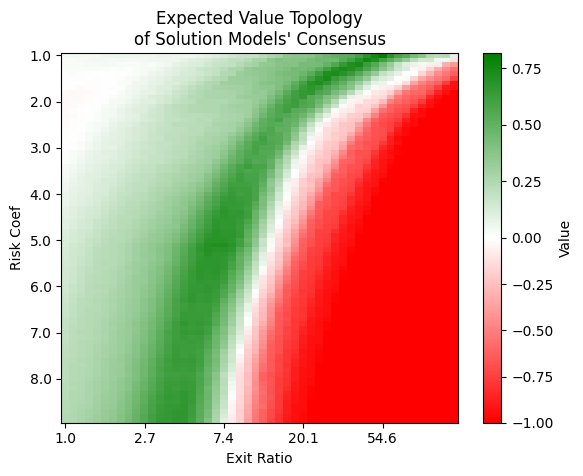

In [110]:
plot_heatmap(EV_arr)

In [41]:
lnplr = 10

y_ = evaluation.generate_solarr_atrplr(x_raw, 1, np.log(lnplr))
idx = ~np.isnan(y_)

y_ = y_[idx]
pvpred = evaluation.meta_bipopvote(xall[idx], threshold=0.99)

v, c = np.unique(pvpred, return_counts=True)
print(v, c)
ps = precision_score(y_, pvpred)
print(ps)

[0 1] [61854 30729]
0.10615379608838556


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.ticker import MaxNLocator

def visualize_loss_topology(
    Z: np.ndarray,
    title: str | None = "Loss Topology",
    extent: tuple | None = None,   # (xmin, xmax, ymin, ymax) if you want axis scales
    savepath: str | None = None,
    show: bool = True,
    nan_color: str = "#FFFFFF",
    dpi: int = 180
):
    """
    Visualize a 2D loss/fitness map where:
      > 0  = most desirable (shown as greens)
        0  = neutral/no-action (light gray)
      -1   = worst (deep red)
    Z: 2D numpy array
    extent: optional axis extent (xmin, xmax, ymin, ymax)
    """

    if Z.ndim != 2:
        raise ValueError("Z must be a 2D numpy array")

    # Handle edge cases
    Z = np.array(Z, dtype=float)
    # Build normalization: anchor vmin at -1 if present, else min(Z); center at 0; vmax at max(Z)
    finite_vals = Z[np.isfinite(Z)]
    if finite_vals.size == 0:
        raise ValueError("Z contains no finite values")
    vmin = -1 if np.nanmin(Z) <= -1 else float(np.nanmin(Z))
    vcenter = 0.0
    vmax = float(np.nanmax(Z))
    # Ensure vmax > vcenter to keep TwoSlopeNorm happy
    if vmax == vcenter:
        vmax = vcenter + 1e-9
    if vmin == vcenter:
        vmin = vcenter - 1e-9

    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # Custom diverging colormap: worst -> neutral -> best
    # dark red -> light gray -> deep green
    cmap = LinearSegmentedColormap.from_list(
        "desirability_map",
        ["#7F0000", "#F0F0F0", "#006D2C"],  # red → light gray → green
        N=256
    )
    cmap.set_bad(nan_color)  # NaNs show as white

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6), dpi=dpi)
    im = ax.imshow(
        Z,
        cmap=cmap,
        norm=norm,
        origin="lower",
        extent=extent,
        interpolation="nearest",
        aspect="auto" if extent else "equal"
    )

    # Contours for structure
    try:
        # Choose a few symmetric levels around 0
        neg_levels = np.linspace(min(vmin, -1), -1e-12, 4)
        pos_levels = np.linspace(vcenter + (vmax - vcenter) / 6, vmax, 4)
        levels = np.concatenate([neg_levels, [vcenter], pos_levels])
        cs = ax.contour(
            Z, levels=levels, colors="k", linewidths=0.5,
            alpha=0.35, origin="lower", extent=extent
        )
        ax.clabel(cs, fmt="%.2g", fontsize=8, inline=True)
    except Exception:
        # Contours can fail if the data is constant; ignore gracefully
        pass

    # Colorbar with meaningful ticks
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # Put labeled anchors at worst (-1), neutral (0), and best (max)
    ticks = np.unique(
        np.round(
            [vmin, -1.0, 0.0, vmax],
            3
        )
    )
    cbar.set_ticks(ticks)
    tick_labels = []
    for t in ticks:
        if np.isclose(t, -1.0):
            tick_labels.append("worst (-1)")
        elif np.isclose(t, 0.0):
            tick_labels.append("neutral (0)")
        elif np.isclose(t, vmin):
            tick_labels.append(f"min ({t:g})")
        elif np.isclose(t, vmax):
            tick_labels.append(f"max ({t:g})")
        else:
            tick_labels.append(f"{t:g}")
    cbar.set_ticklabels(tick_labels)
    cbar.ax.set_ylabel("Desirability (higher is better)", rotation=90)

    # Axes cosmetics
    ax.set_title(title or "Loss Topology", pad=10)
    ax.grid(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Frame styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.0)
        spine.set_alpha(0.6)

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


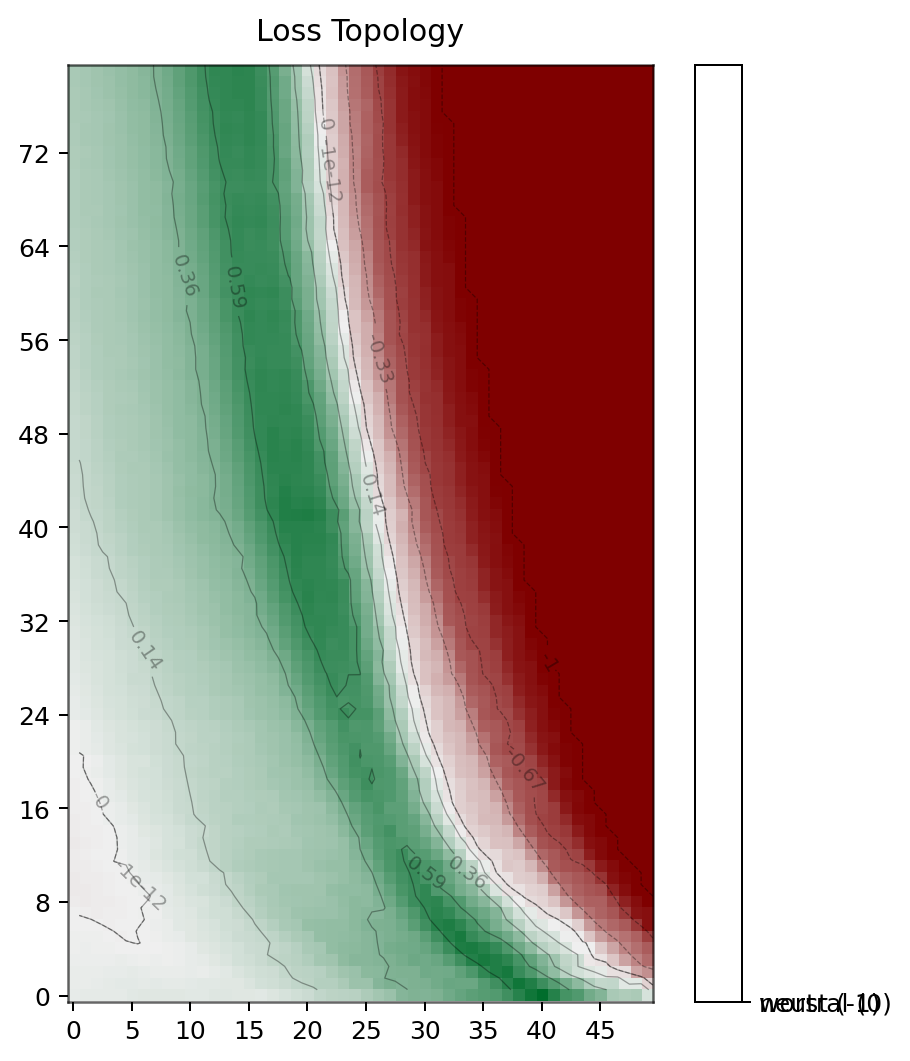

In [111]:
visualize_loss_topology(EV_arr)

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

def visualize_loss_topology_3d(
    Z: np.ndarray,
    title: str = "3D Loss/Desirability Topology",
    extent: tuple | None = None,   # (xmin, xmax, ymin, ymax) if you want meaningful axes
    show_floor_contours: bool = False,
    nan_color: str = "#FFFFFF",
    stride: int = 1,               # plot every Nth point for speed
    dpi: int = 160,
    elev: float = 35,
    azim: float = 135
):
    """
    Visualize a 2D array Z as a 3D surface where:
       > 0  = most desirable (green)
         0  = neutral/no-action (light gray)
        -1  = worst (red)

    Parameters
    ----------
    Z : 2D np.ndarray
        Desirability map (can include NaNs).
    extent : tuple | None
        (xmin, xmax, ymin, ymax) for axis scaling. If None, uses index coordinates.
    show_floor_contours : bool
        If True, adds filled contours projected onto the z=min plane.
    stride : int
        Subsample factor for large arrays (>=1). Use 2 or 3 for speed on huge grids.
    """

    if Z.ndim != 2:
        raise ValueError("Z must be 2D")

    Z = np.array(Z, dtype=float)
    m, n = Z.shape

    # Build X, Y mesh
    if extent is None:
        x = np.arange(n)
        y = np.arange(m)
    else:
        xmin, xmax, ymin, ymax = extent
        x = np.linspace(xmin, xmax, n)
        y = np.linspace(ymin, ymax, m)
    X, Y = np.meshgrid(x, y)

    # Clean and normalize
    finite = np.isfinite(Z)
    if not finite.any():
        raise ValueError("Z contains no finite values")

    vmin = -1 if np.nanmin(Z) <= -1 else float(np.nanmin(Z))
    vcenter = 0.0
    vmax = float(np.nanmax(Z))
    if vmax == vcenter: vmax = vcenter + 1e-9
    if vmin == vcenter: vmin = vcenter - 1e-9
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    cmap = LinearSegmentedColormap.from_list(
        "desirability_map_3d",
        ["#7F0000", "#F0F0F0", "#006D2C"],  # red → light gray → green
        N=256
    )
    cmap.set_bad(nan_color)

    # Optional downsampling for performance
    sl = slice(0, None, max(1, stride))
    Xs, Ys, Zs = X[sl, sl], Y[sl, sl], Z[sl, sl]

    # Figure / 3D axes
    fig = plt.figure(figsize=(8, 6), dpi=dpi, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Surface
    surf = ax.plot_surface(
        Xs, Ys, Zs,
        rstride=1, cstride=1,
        cmap=cmap, norm=norm,
        linewidth=0, antialiased=True,
        shade=True
    )

    # Floor contours (projected)
    if show_floor_contours:
        zfloor = np.nanmin(Z) if np.isfinite(Z).any() else -1.0
        ax.contourf(
            X, Y, Z,
            zdir='z', offset=zfloor,
            levels=np.linspace(vmin, vmax, 15),
            cmap=cmap, norm=norm, antialiased=True
        )

    # Colorbar with meaningful anchors
    # Manually create a ScalarMappable for the colorbar
    from matplotlib.cm import ScalarMappable

    # build the mappable separate from the 3D surface
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(Z)           # <- important: give it real data
    sm.set_clim(vmin, vmax)   # <- and explicit limits

    # use constrained layout or widen the pad so labels have room
    cbar = fig.colorbar(sm, ax=ax, pad=0.08)  # avoid tiny shrink; give it space

    # robust ticks that actually live inside [vmin, vmax]
    ticks = []
    for t in (vmin, -1.0, 0.0, vmax):
        if vmin <= t <= vmax:
            ticks.append(t)
    # ensure sorted and unique
    ticks = sorted(set(ticks))
    cbar.set_ticks(ticks)

    labels = []
    for t in ticks:
        if np.isclose(t, -1.0): labels.append("worst (-1)")
        elif np.isclose(t, 0.0): labels.append("neutral (0)")
        elif np.isclose(t, vmin): labels.append(f"min ({t:g})")
        elif np.isclose(t, vmax): labels.append(f"max ({t:g})")
        else: labels.append(f"{t:g}")
    cbar.set_ticklabels(labels)

    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Desirability (higher is better)")

    # Cosmetics
    ax.set_title(title, pad=12)
    if extent is not None:
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
    ax.view_init(elev=elev, azim=azim)

    # Make 0-level visually explicit (optional line on the z-axis)
    # ax.plot([x.min(), x.max()], [y.min(), y.min()], [0, 0], color='k', alpha=0.15)

    # Tighter layout
    plt.tight_layout()
    plt.show()


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

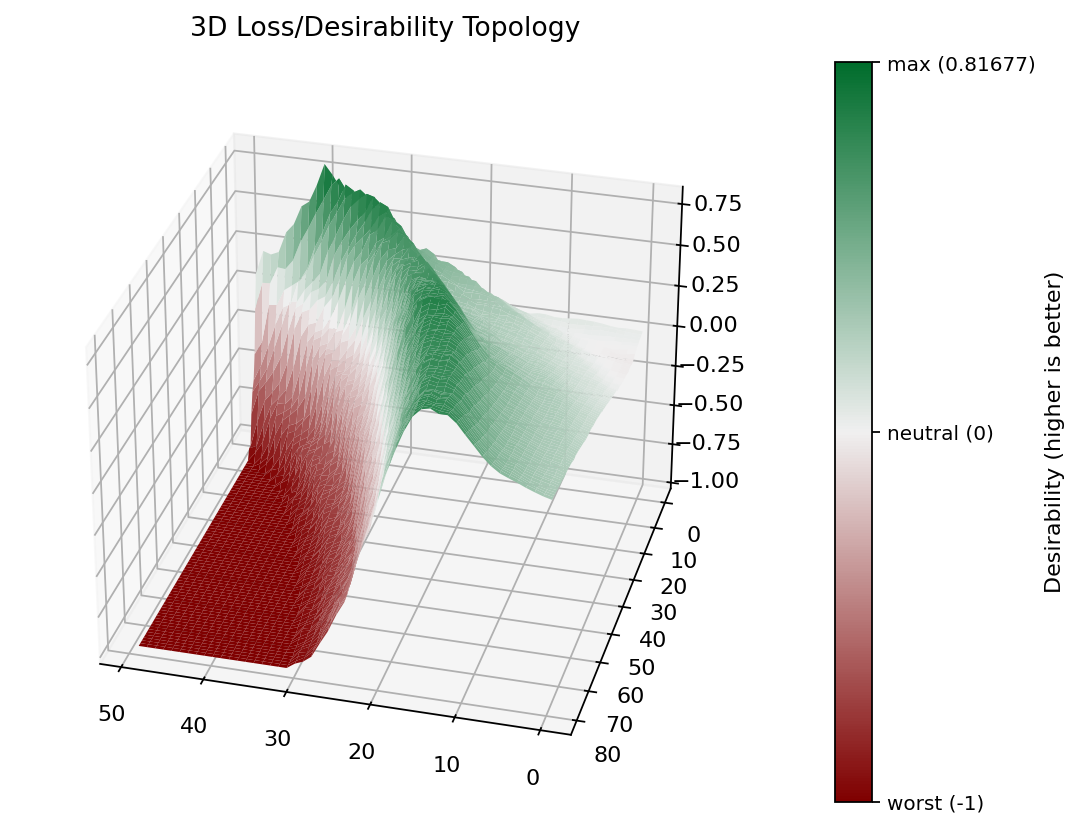

In [122]:
visualize_loss_topology_3d(EV_arr, elev=30, azim=105)

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_loss_topology_3d_heatmap(
    Z: np.ndarray,
    title: str = "3D Heatmap (Desirability)",
    extent: tuple | None = None,      # (xmin, xmax, ymin, ymax)
    elev: float = 35,
    azim: float = 135,
    stride: int = 1,                   # plot every Nth point
    nan_color: str = "#FFFFFF",
    dpi: int = 160,
    ticks: list[float] | None = None   # custom colorbar ticks (optional)
):
    """
    Plots a 3D surface colored as a 'heatmap' with:
      - red↔white↔green when data spans negative and positive (center at 0)
      - white→green when all non-negative
      - red→white when all non-positive

    Z: 2D array (can include NaNs)
    """

    # ---- validate & prep ----
    Z = np.asarray(Z, dtype=float)
    if Z.ndim != 2:
        raise ValueError("Z must be 2D.")
    if not np.isfinite(Z).any():
        raise ValueError("Z contains no finite values.")

    m, n = Z.shape
    if extent is None:
        x = np.arange(n); y = np.arange(m)
    else:
        xmin, xmax, ymin, ymax = extent
        x = np.linspace(xmin, xmax, n)
        y = np.linspace(ymin, ymax, m)
    X, Y = np.meshgrid(x, y)

    data_min = float(np.nanmin(Z))
    data_max = float(np.nanmax(Z))

    # ---- colormap + normalization per your spec ----
    if data_min < 0 < data_max:
        cmap = LinearSegmentedColormap.from_list("r_w_g", ["#7F0000", "#F0F0F0", "#0087B4"])
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0.0, vmax=data_max)
    elif data_min >= 0:
        cmap = LinearSegmentedColormap.from_list("w_g", ["white", "green"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)
    else:  # data_max <= 0
        cmap = LinearSegmentedColormap.from_list("r_w", ["red", "white"])
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    cmap.set_bad(nan_color)

    # ---- optional downsample for speed ----
    sl = slice(0, None, max(1, stride))
    Xs, Ys, Zs = X[sl, sl], Y[sl, sl], Z[sl, sl]

    # ---- figure (no constrained/tight layout to avoid colorbar engine clashes) ----
    fig = plt.figure(figsize=(8, 6), dpi=dpi)
    ax = fig.add_subplot(111, projection="3d")

    # 3D surface colored by heatmap scheme
    surf = ax.plot_surface(
        Xs, Ys, Zs,
        cmap=cmap, norm=norm,
        linewidth=0, antialiased=True, shade=True
    )

    # ---- stable colorbar on a dedicated axis ----
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(Z)
    sm.set_clim(data_min, data_max)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)

    # default ticks: min, (−1 if in-range), 0 if in-range, max — or user-supplied
    if ticks is None:
        candidates = [data_min, 0.0, data_max]
        # include -1 only if it lies within [data_min, data_max]
        if data_min <= -1.0 <= data_max:
            candidates.insert(1, -1.0)
        ticks = sorted(set(t for t in candidates if data_min <= t <= data_max))

    cbar.set_ticks(ticks)
    # friendly labels
    labels = []
    for t in ticks:
        if np.isclose(t, 0.0) and (data_min < 0 < data_max):
            labels.append("neutral (0)")
        elif np.isclose(t, -1.0):
            labels.append("worst (-1)")
        elif np.isclose(t, data_min):
            labels.append(f"min ({t:g})")
        elif np.isclose(t, data_max):
            labels.append(f"max ({t:g})")
        else:
            labels.append(f"{t:g}")
    cbar.set_ticklabels(labels)
    cbar.set_label("Desirability (higher is better)")

    # ---- view & axes ----
    ax.set_title(title, pad=10)
    if extent is not None:
        ax.set_xlim(x.min(), x.max()); ax.set_ylim(y.min(), y.max())
    ax.view_init(elev=elev, azim=azim)

    plt.show()


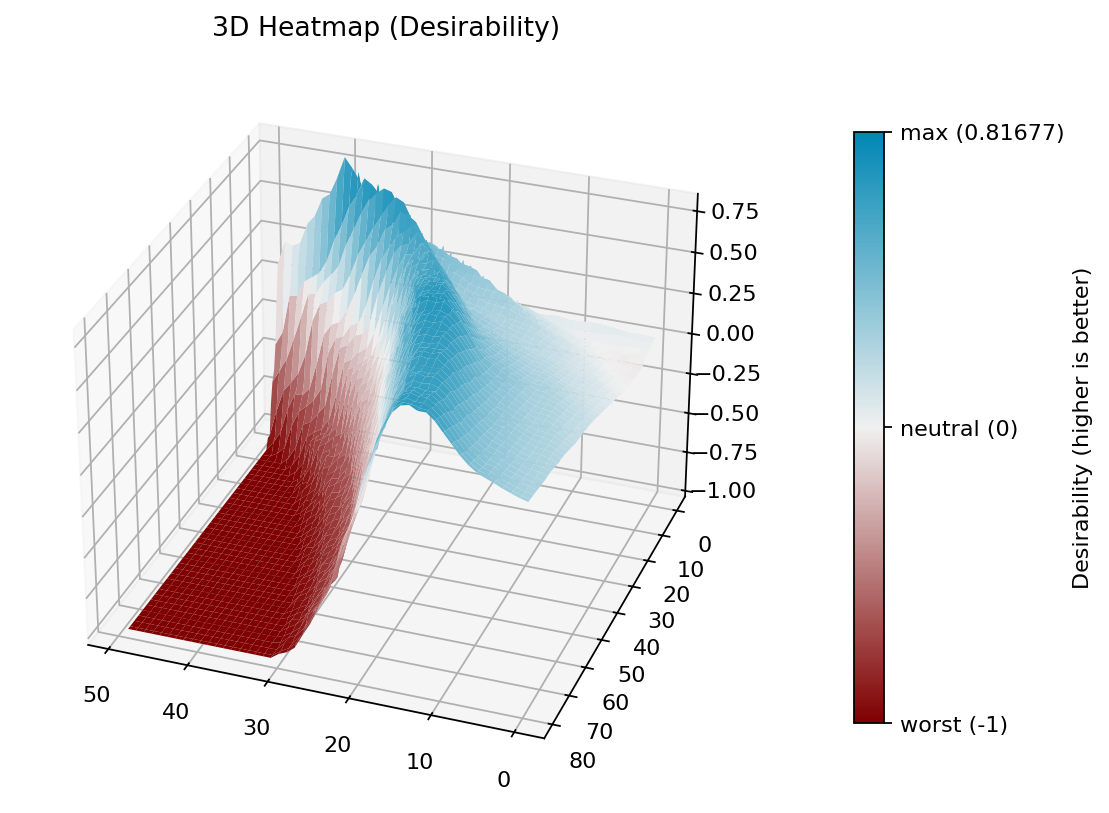

In [156]:
visualize_loss_topology_3d_heatmap(EV_arr, elev=30, azim=110)

In [ ]:
import numpy as np
from hmmlearn.hmm import MultinomialHMM

def learn_hmm_states(predictions: np.ndarray, n_states: int):
    # predictions: (n_models, seq_len)
    uniq, emissions = np.unique(predictions, axis=0, return_inverse=True)
    n_emissions = uniq.shape[0]

    #one-hot encode
    seq_len = emissions.shape[0]
    X = np.zeros((seq_len, n_emissions), dtype=int)
    X[np.arange(seq_len), emissions] = 1

    lengths = [seq_len]
    model = MultinomialHMM(n_components=n_states, n_iter=10, verbose=True)
    model.n_features = n_emissions
    model.fit(X, lengths)

    hidden_states = model.predict(X, lengths)
    return hidden_states, model

In [14]:
states, hmmmodel = learn_hmm_states(xall, n_states=5)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
         1 -661892.81830388             +nan
         2 -369007.24203799 +292885.57626589
         3 -353831.24145783  +15176.00058016
         4 -346927.14697864   +6904.09447919
         5 -341887.09561766   +5040.05136097
         6 -338027.89648780   +3859.19912986
         7 -335309.93434658   +2717.96214122
         8 -333731.78573084   +1578.14861574
         9 -332771.82096494    +959.96476590
        10 -332118.85048461    +652.97048033


In [15]:
print(states)

[2 1 2 ... 1 2 1]


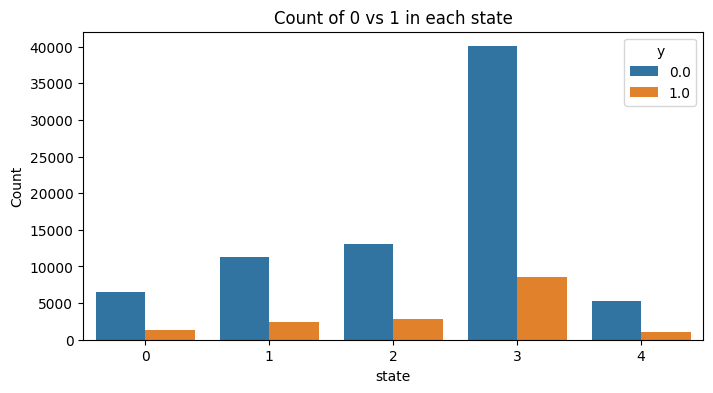

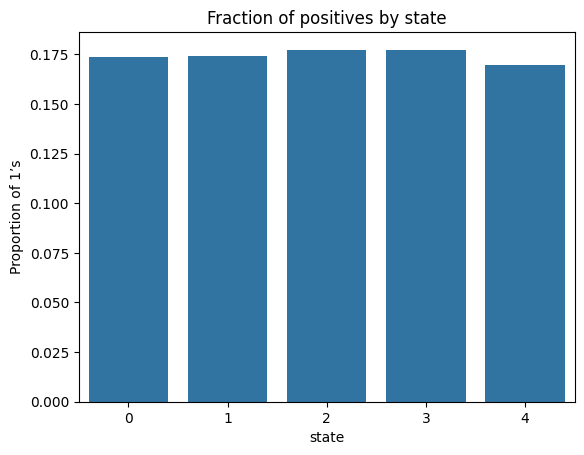

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#assume `states` is a 1d array of labels, and `y` is a 1d 0/1 array
df = pd.DataFrame({"state": states, "y": y_})

#grouped countplot
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="state", hue="y")
plt.ylabel("Count")
plt.title("Count of 0 vs 1 in each state")
plt.show()

#—or—  to see proportions:
prop = df.groupby("state")["y"].mean().reset_index()
sns.barplot(data=prop, x="state", y="y")
plt.ylabel("Proportion of 1's")
plt.title("Fraction of positives by state")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(xall, y_, test_size=0.3, shuffle=True, random_state=0)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
model, history = evaluation.standard_NN_construction(X_train, y_train, epochs=50, verbose=1)
evaluation.standard_NN_evaluation(X_train, X_test, y_train, y_test, model, history, run_dir='', vizout=False, show=True)

In [ ]:
np.unique(preds, return_counts=True)

In [ ]:
pd.DataFrame(x_[:, 0]).hist(bins=200)

In [ ]:
transforms.get_oplist(forest[0])

In [ ]:
for i in range(1,1):
    print('hello')

In [ ]:
import serialization
import matplotlib.pyplot as plt

path, scores = serialization.load_deeplist(where='../../runs/run_26/path_pscr.hstry')

plt.plot(range(len(scores)), scores)

In [ ]:
data = pd.read_csv("../../data/ES15.csv")
x_raw = data.values
best_forest = serialization.load_forest(where='../../runs/run_49/best.4st')
import optimize
x_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_raw
)
_, __, best_scores = evaluation.evaluate_forest_newer(x_, close_prices=x_raw[:, 3], lag_range=(1, 3))
loss = optimize.loss_fc(best_scores)
print(loss)

for i in range(len(best_forest)):
    print(transforms.get_oplist(best_forest[i]))

In [ ]:
from sklearn.linear_model import LogisticRegression
# label train‐vs‐test rows
X_tv = np.vstack([X_train, X_test])
y_tv = np.array([0]*len(X_train) + [1]*len(X_test))
adv = LogisticRegression().fit(X_tv, y_tv)
print("AUC distinguishing train vs test:", adv.score(X_tv, y_tv))

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from transforms import forest2features

# 1) Define the transformer that wraps your feature generator
class Forest2Features(BaseEstimator, TransformerMixin):
    def __init__(self, population):
        self.population = population

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is your raw x_raw array (n_samples, 4)
        return forest2features(self.population, X)

# 2) Prepare your raw data and target
#    Assume x_raw is an (N, 4) ndarray and best_forest is defined
#    Column 2 is the 'close' price
raw_prices = x_raw[:, 3]
# compute 1-step log-return target of length N-1
y_logret = np.log(raw_prices[1:] / raw_prices[:-1])
# align features by dropping the last raw row so X_raw_aligned.shape[0] == y_logret.shape[0]
X_raw_aligned = x_raw[:-1, :]

noise = np.random.rand(X_raw_aligned.shape[0], 1)

X_raw_aligned = np.hstack([X_raw_aligned, noise])

# 3) Build the pipeline
pipe = Pipeline([
    ("fe",     Forest2Features(population=best_forest)),
    ("scaler", StandardScaler()),
    ("lr",     LinearRegression())
])

# 4) Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw_aligned), 1):
    X_tr, X_te = X_raw_aligned[train_idx], X_raw_aligned[test_idx]
    y_tr, y_te = y_logret     [train_idx], y_logret     [test_idx]

    #y_tr = np.random.permutation(y_tr)

    pipe.fit(X_tr, y_tr)
    
    perm = permutation_importance(pipe,
                              X_tr, y_tr,
                              n_repeats=5,
                              random_state=0,
                              scoring='r2')
    perm_importances = pd.Series(perm.importances_mean)
    print(perm_importances)
    #print("impt: ",perm_importances.max(),perm_importances[4])

    score = pipe.score(X_te, y_te)
    y_pred = pipe.predict(X_te)
    visualization.visualize_regression_eval(y_te, y_pred, show=False)
    print(f"Fold {fold} R²: {score:.4f}")


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from transforms import forest2features

# 1) Define transformer wrapping your feature generator\class Forest2Features(BaseEstimator, TransformerMixin):
def __init__(self, population):
    self.population = population

def fit(self, X, y=None):
        return self

def transform(self, X):
        return forest2features(self.population, X)

# 2) Prepare raw data and target
#    Assume x_raw is an (N, 4) ndarray and best_forest is defined; column 2 is 'close'
raw_prices = x_raw[:, 3]
# compute 1-step log-return target of length N-1
y_logret = np.log(raw_prices[1:] / raw_prices[:-1])
# align features by dropping the last raw row so X_raw_aligned.shape[0] == y_logret.shape[0]
X_raw_aligned = x_raw[:-1, :]

# 3) Build pipeline
pipe = Pipeline([
    ("fe",     Forest2Features(population=best_forest)),
    ("scaler", StandardScaler()),
    ("lr",     LinearRegression())
])

# 4) Time-series cross-validation with post-feature-generation printing
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_raw_aligned), start=1):
    print(f"\n--- Fold {fold} ---")

    # raw train/test splits
    X_tr_raw, X_te_raw = X_raw_aligned[train_idx], X_raw_aligned[test_idx]
    y_tr,      y_te     = y_logret[train_idx],      y_logret[test_idx]

    # generate features using the transformer step
    fe = pipe.named_steps['fe']
    X_te_feats = fe.transform(X_te_raw)

    # inspect the generated features for the test split
    print("First 3 rows of generated test features:")
    print(X_te_feats[:3])
    print("Last 3 rows of generated test features:")
    print(X_te_feats[-3:])

    # fit the full pipeline (features -> scaler -> model)
    pipe.fit(X_tr_raw, y_tr)
    score = pipe.score(X_te_raw, y_te)
    print(f"Fold {fold} R²: {score:.4f}")


In [ ]:
dataext = pd.read_csv("../../data/ES15_ext.csv")
x_ext = dataext.values

xext_ = transforms.forest2features(
    population=best_forest,
    x_raw=x_ext
)

noise = np.random.rand(xext_.shape[0], 1)

xext_ = np.hstack([xext_, noise])


xext_ = scaler.transform(xext_)

ynewe = np.roll(x_ext[:, 3], shift=-1)
#np.random.shuffle(ynewe)
y_e = np.log(ynewe / x_ext[:, 3])

evaluation.standard_LM_evaluation(X_train, xext_, y_train, y_e, model, dirpath, vizout=True, show=True)


In [ ]:
scores = []

for i in range(6,x_raw.shape[0] -1):
    x_i = transforms.forest2features(
        population=best_forest,
        x_raw=x_raw[:i]
    )
    
    x_i[:, 0] = 1

    y_i = np.log( x_raw[1:i, 3] / x_raw[:i-1, 3] )
    
    x_i = np.hstack([x_i, np.random.rand(i, 1)])
    x_i = x_i[:-1]
    
    x_i = scaler.transform(x_i)
    
    print(model.score(x_i, y_i))

In [ ]:
x = pd.read_csv("../../data/ES15_ext.csv")
xr = x.values

x = transforms.forest2features(
    population=best_forest,
    x_raw=xr
)

x[:, 0] = 1
noise = np.random.rand(x.shape[0], 1)

x = np.hstack([x, noise])

x = scaler.transform(x)

ynewe = np.roll(xr[:, 3], shift=-1)
#np.random.shuffle(ynewe)
y = (ynewe / xr[:, 3]) - 1

pred = model.predict(x)

evaluation.standard_LM_evaluation(x, x, y, y, model, dirpath, vizout=True, show=True)


In [ ]:
mask = np.abs(model.predict(X_test)) > 0.0005
frac = mask.mean()
print(frac)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sign_accuracy_comparative(y_true, y_pred, show=True):
    """
    Plot two accuracy curves versus |y_pred| threshold, starting at 0.00025,
    and restrict x-axis to [0, 0.0025].

    - 'center': accuracy for predictions with |y_pred| <= threshold
    - 'extremes': accuracy for predictions with |y_pred| >= threshold

    Args:
        y_true: array-like of true values
        y_pred: array-like of predicted values
        show: whether to display the plot

    Returns:
        thresholds: filtered array of |y_pred| thresholds (>=0.00025)
        center_acc: accuracy for |y_pred| <= threshold
        extremes_acc: accuracy for |y_pred| >= threshold
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    abs_pred = np.abs(y_pred)
    true_sign = np.sign(y_true)
    pred_sign = np.sign(y_pred)

    # All unique thresholds, sorted ascending
    all_thresholds = np.unique(abs_pred)
    all_thresholds.sort()

    # Start at a more stable region: ignore thresholds below 0.00025
    thresholds = all_thresholds[all_thresholds >= 0.0001]

    # Compute accuracies at each filtered threshold
    center_acc = np.array([
        np.mean(true_sign[abs_pred <= t] == pred_sign[abs_pred <= t])
        for t in thresholds
    ])
    extremes_acc = np.array([
        np.mean(true_sign[abs_pred >= t] == pred_sign[abs_pred >= t])
        for t in thresholds
    ])

    if show:
        plt.figure()
        plt.plot(thresholds, center_acc, marker='o', linestyle='-',
                 label='|y_pred| ≤ threshold (center)')
        plt.plot(thresholds, extremes_acc, marker='^', linestyle='--',
                 label='|y_pred| ≥ threshold (extremes)')
        plt.xlabel("|y_pred| Threshold")
        plt.ylabel("Sign Prediction Accuracy")
        plt.title("Accuracy from Center vs. Extremes (from 0.00025)")
        plt.legend()
        plt.xlim(0.0001, 0.0025)
        plt.show()

    return thresholds, center_acc, extremes_acc


In [ ]:
y_pred_test = model.predict(X_test)
sign_accuracy_comparative(y_test, y_pred_test)


In [ ]:
_ = sign_accuracy_comparative(y, pred)

In [ ]:


for i in range(1,len(xr)):
    p = round(model.predict(x[:i])[-1], 5)
    if(abs(p) > 0.0005):
        print(f'time: {xr[i, 0]}\tprice: {xr[i]}\tpred: {p}')